# Homework 2 Excercise 3 - Image Denoiser

Brennan McFarland  
bfm21

In order to denoise an image, we must first create an appropriate representation of it in memory.  We can represent the noisy image as an array of binary pixel values y<sub>i</sub> in {-1, +1} where i is the pixel number, -1 is black and 1 is white.  We can thus derive the most probable denoised image based on the noisy image.

## Load Image

The greyscale values of the image are on the scale of[ -1.0 , 1.0 ]


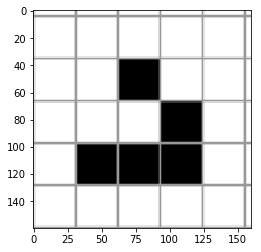

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imtool
from scipy.signal import convolve2d as conv2d
from skimage import io

nratio = .1
imorg = io.imread('glider.png', as_grey=True)
plt.imshow(imorg, cmap='gray')

black_value, white_value = -1.0, 1.0 # np.amin(imorg), np.amax(imorg)
print("The greyscale values of the image are on the scale of[", black_value, ",", white_value, "]")

## Add Noise

In [5]:
def addnoise(imorg, nratio=0.1):
    imnsy = imorg.copy()
    # convert '0' to '-1'
    # imnsy[imnsy == 0] = -1
    # create random value to indicate flipping pixels
    index = np.random.rand(*imnsy.shape)
    # flip pixels to generate noisy image
    for r in range(len(imnsy)):
        for c in range(len(imnsy[r])):
            if index[r][c] < nratio:
                imnsy[r][c] = np.random.uniform(0.0, 1.0)
    return imnsy

In [6]:
def showimgs(*args, ncol=2):
    if not args:
        return
    # initialize figure with specific size
    plt.figure(figsize=(16, 10))
    # compose subplot index
    nrow = np.ceil(len(args) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img in enumerate(args):
        plt.subplot(subindex + i + 1)
        plt.imshow(img, cmap='gray')

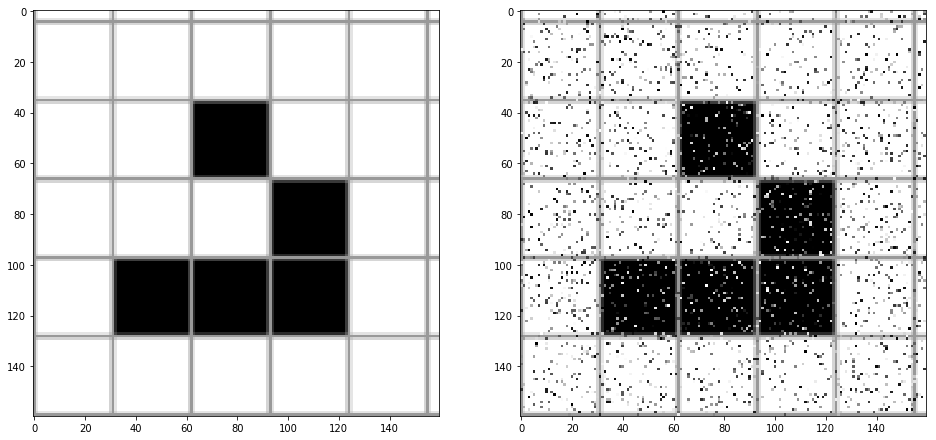

In [7]:
imnsy = addnoise(imorg, nratio = 0.1)
showimgs(imorg, imnsy)

## Probability/Energy Function

We can characterize the relationship between the noisy and denoised image as the energy function
$$E(X,Y) = \alpha\sum\limits_{i} x_i - \beta \sum\limits_{i,j} x_i x_j - \eta \sum\limits_{i} x_i y_i $$
where $\alpha$ is the noise bias, eg, the proportion of white pixels in the image on a scale of [-1, 1],  
$\beta$ is the coefficient for the relationship between a pixel and its neighbors for $\beta$>0,  
and $\eta$ is the coefficient for the relationship between a pixel's noisy and denoised value for $\eta$>0    
Thus the joint distribution over $x$ and $y$ is
$$p(x, y) = \frac{1}{Z} \exp\{-E(x,y)\}$$

## Solving the Model

Specified in this way, denoising the image is just a matter of minimizing the energy function, which we can do via gradient descent.

In [20]:
showproc_steps = 10
def denoise(imnsy, efunc, algorithm, showproc = False):
    # show noisy image
    if showproc:
        plt.imshow(imnsy, cmap='gray')
        plt.title('Noisy Image')
        plt.show()
    return algorithm(imnsy, efunc, showproc)

In [21]:
def simulated_annealing(imnsy, efunc, showproc = False):
    imrec = imnsy.copy()
    # set initial temp and delta temp
    T = .5
    dT = .01
    i = 1 # TODO: remove this
    while T > 0:
        i += 1
        # calculate energy function (gradient can be ignored)
        E, dE = efunc(imrec, imnsy)
        imrec_temp = imrec.copy()
        # randomly set a bunch of pixels, and make that the new state if it lowers the energy function
        # TODO: why is it going to black sometimes?
        index = np.random.rand(*imnsy.shape)
        for r in range(len(imrec)):
            for c in range(len(imrec[r])):
                if index[r][c] < nratio:
                    imrec_temp[r][c] = np.random.uniform(black_value, white_value)
        # imrec_temp[np.random.uniform() < .1] = np.random.uniform(black_value, white_value) # change .1 to the variable val of nratio
        newE, newdE = efunc(imrec_temp, imnsy)
        if newE < E:
            imrec = imrec_temp
        
        if showproc and i%showproc_steps == 0:
            plt.imshow(imrec, cmap='gray')
            plt.title('Recovered Image (Iter-%d)' % i)
            plt.show()
        T -= dT
    return imrec

In [22]:
def gradient_descent(imnsy, efunc, showproc = False):
    # initialize recoverred image as noisy image
    imrec = imnsy.copy()
    # map from [0, 1] to [-1, 1]
    for r in range(len(imrec)):
            for c in range(len(imrec[r])):
                imrec[r][c] = imrec[r][c]*2.0-1.0
    # calculate energy function and its gradients
    E, dE = efunc(imrec, imnsy)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E:
        Etmp = E
        # update image by setting pixels to random values, which could decrease energy function
        imrec[dE < 0] = np.random.uniform(black_value, white_value)
        for r in range(len(imrec)):
            for c in range(len(imrec[r])):
                if dE[r][c] < 0:
                    imrec[r][c] = np.random.uniform(black_value, white_value)
        # calculate energy function with revised image
        [E, dE] = efunc(imrec, imnsy)
        # update iteration count
        i += 1
        # show revised image
        if showproc and i%showproc_steps == 0:
            plt.imshow(imrec, cmap='gray')
            plt.title('Recovered Image (Iter-%d)' % i)
            plt.show()
    # map from [-1, 1] to [0, 1]
    for r in range(len(imrec)):
            for c in range(len(imrec[r])):
                imrec[r][c] = (imrec[r][c]+1.0)/2.0
    # return recovered image
    return imrec

In [23]:
# TODO: fix the below to work for greyscale

In [24]:
def extendEnergyFunction(hidden, observation, 
                         alpha=1, beta=1, gamma=1, phi=1, sigma=1, eta=1):
    # template alpha
    Ta = np.asarray([[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]])
    # template beta
    Tb = np.asarray([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    # template gamma
    Tr = np.asarray([[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]])
    # template phi
    Tp = np.asarray([[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    # template sigma
    Ts = np.asarray([[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]])
    
    # generate parameter matrix alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * conv2d(hidden, T, 'same'))
    # generate parameter matrix beta
    matB = conv2d(hidden, Tb, 'same')
    # generate parameter matrix gamma
    matR = conv2d(hidden, Tr, 'same')
    # generate parameter matrix phi
    matP = conv2d(hidden, Tp, 'same')
    # generate parameter matrix sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * conv2d(hidden, T, 'same'))
        
    # calculate energy map
    mapE = -alpha*matA - sigma*matS - hidden*(beta*matB + gamma*matR + phi*matP + eta*observation)
    # get energy value as mean of map
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

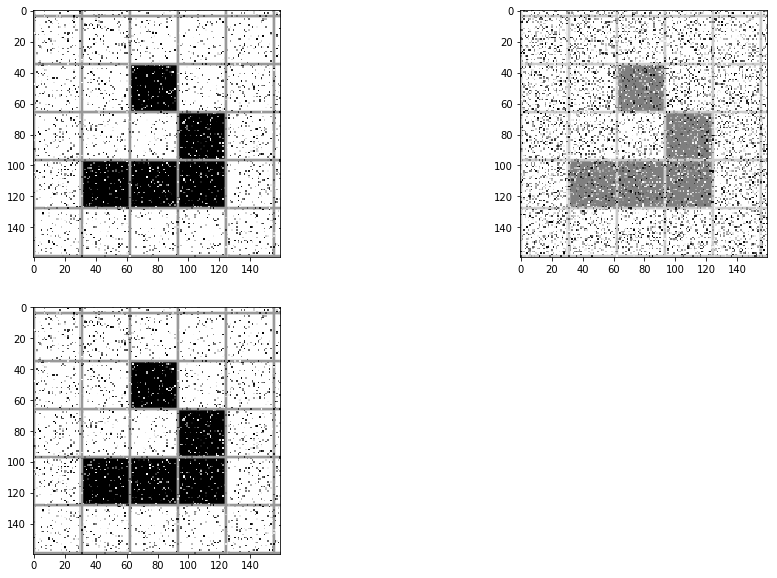

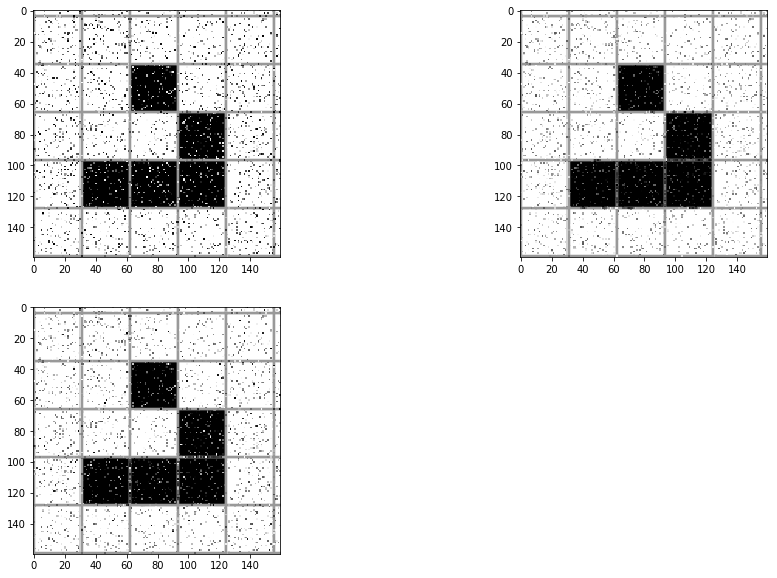

In [25]:
medFilterProtectA = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0.1, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0, eta=0)

medFilterProtectS = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0.1, eta=0)

# denoise image with new energy functions
imrecMedProtectA = denoise(imnsy, medFilterProtectA, simulated_annealing)
imrecMedProtectS = denoise(imnsy, medFilterProtectS, simulated_annealing)

# compare result from different median filters
showimgs(imnsy, imrecMedProtectA, imrecMedProtectS)

# and compare that with gradient descent
imrecMedProtectAGradDesc = denoise(imnsy, medFilterProtectA, gradient_descent)
imrecMedProtectSGradDesc = denoise(imnsy, medFilterProtectS, gradient_descent)
showimgs(imnsy, imrecMedProtectAGradDesc, imrecMedProtectSGradDesc)


With luck, the simulated annealing doesn't get stuck in a local minimum (if it does, running the denoiser again should fix it).  The different filters can produce varying results, but by taking the average of them we can get a more stable denoised image:

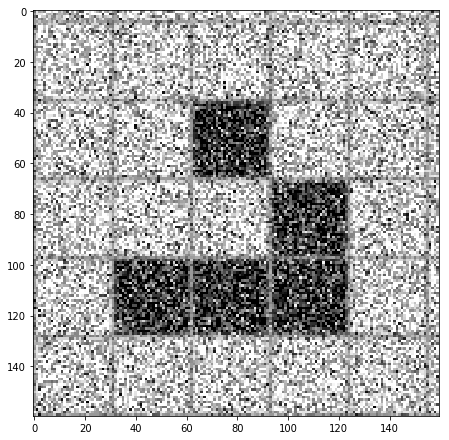

In [209]:
#TODO: average them like the above
showimgs(np.mean(np.array([imrecMedProtectA, imrecMedProtectS]), axis=0))